In [ ]:
import pandas as pd
import numpy as np

csv_path = '/content/student_data.csv'
df = pd.read_csv(csv_path, sep=';')
print("Columns in dataset:", df.columns.tolist())
print("First 5 rows:\n", df.head())


Columns in dataset: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
First 5 rows:
   school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        

In [ ]:
keywords = ['g3', 'final', 'score', 'grade']

target_col = None
for col in df.columns:
    for key in keywords:
        if key.lower() in col.lower():
            target_col = col
            break
    if target_col:
        break

if target_col is None:
    raise ValueError(f"No final grade column found. Available columns: {df.columns.tolist()}")

print(f"Detected final grade column: {target_col}")

# Convert target to numeric
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
valid_count = df[target_col].notna().sum()
print(f"Number of valid numeric values in '{target_col}': {valid_count}")

# Drop rows where target is NaN
df = df[df[target_col].notna()]

if df.shape[0] == 0:
    raise ValueError(f"No valid rows left after preprocessing. Check your CSV and column '{target_col}'.")

print(f"Dataset shape after filtering: {df.shape}")

y = df[target_col]
X = df.drop([target_col], axis=1)

Detected final grade column: G3
Number of valid numeric values in 'G3': 395
Dataset shape after filtering: (395, 33)


In [ ]:
expected_numerical = ['Medu','Fedu','traveltime','studytime','failures','famrel',
                      'freetime','goout','health','absences','G1','G2']

for col in expected_numerical:
    if col not in X.columns:
        print(f"Column '{col}' missing in dataset. Adding it with default 0 values.")
        X[col] = 0
    else:
        # Convert numeric-like strings to numbers
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Check dataset size
if df.shape[0] < 2:
    raise ValueError("Not enough rows to train/test split. Need at least 2 rows.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)

models = {
    'Random_Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear_Regression': LinearRegression(),
    'SVM': SVR()
}

results = {}

for name, model_obj in models.items():
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model_obj)
    ])
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    import numpy as np
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    results[name] = [rmse_train, rmse_test, mae_train, mae_test]

    if name == 'Random_Forest':
        joblib.dump(pipeline, 'student_grade_pred_model_colab.pkl')

print("Training complete. Model saved as 'student_grade_pred_model_colab.pkl'")
for k, v in results.items():
    print(k, v)

Training complete. Model saved as 'student_grade_pred_model_colab.pkl'
Random_Forest [np.float64(0.5942796937725364), np.float64(1.9963187640241566), 0.3559493670886076, 1.1918987341772151]
Linear_Regression [np.float64(1.680194736860462), np.float64(2.3783697847961376), 1.1644823437827705, 1.6466656197147522]
SVM [np.float64(1.994288457179725), np.float64(2.0709040400845073), 1.145604712405406, 1.2121850574287167]


In [ ]:
model = joblib.load('student_grade_pred_model_colab.pkl')

def numeric_to_letter(grade):
    if grade >= 16:
        return 'A'
    elif grade >= 14:
        return 'B'
    elif grade >= 12:
        return 'C'
    elif grade >= 10:
        return 'D'
    else:
        return 'F'

# Example student input
student_input = {
    'school': 'GP',
    'sex': 'F',
    'age': 17,
    'address': 'U',
    'Medu': 4,
    'Fedu': 4,
    'traveltime': 1,
    'studytime': 2,
    'failures': 0,
    'famrel': 4,
    'freetime': 3,
    'goout': 2,
    'health': 5,
    'absences': 4,
    'G1': 15,
    'G2': 16
}

# Ensure all columns from training are present in student input
for col in X_train.columns:
    if col not in student_input:
        # Fill numeric columns with 0, categorical with 'missing'
        if col in expected_numerical:
            student_input[col] = 0
        else:
            # Check if column in training data is numeric
            if pd.api.types.is_numeric_dtype(X_train[col]):
                student_input[col] = 0
            else:
                student_input[col] = 'missing'

student_df = pd.DataFrame([student_input])
predicted_score = model.predict(student_df)[0]
letter_grade = numeric_to_letter(predicted_score)

print(f"Predicted Final Score: {predicted_score:.2f}")
print(f"Predicted Letter Grade: {letter_grade}")

Predicted Final Score: 15.39
Predicted Letter Grade: B


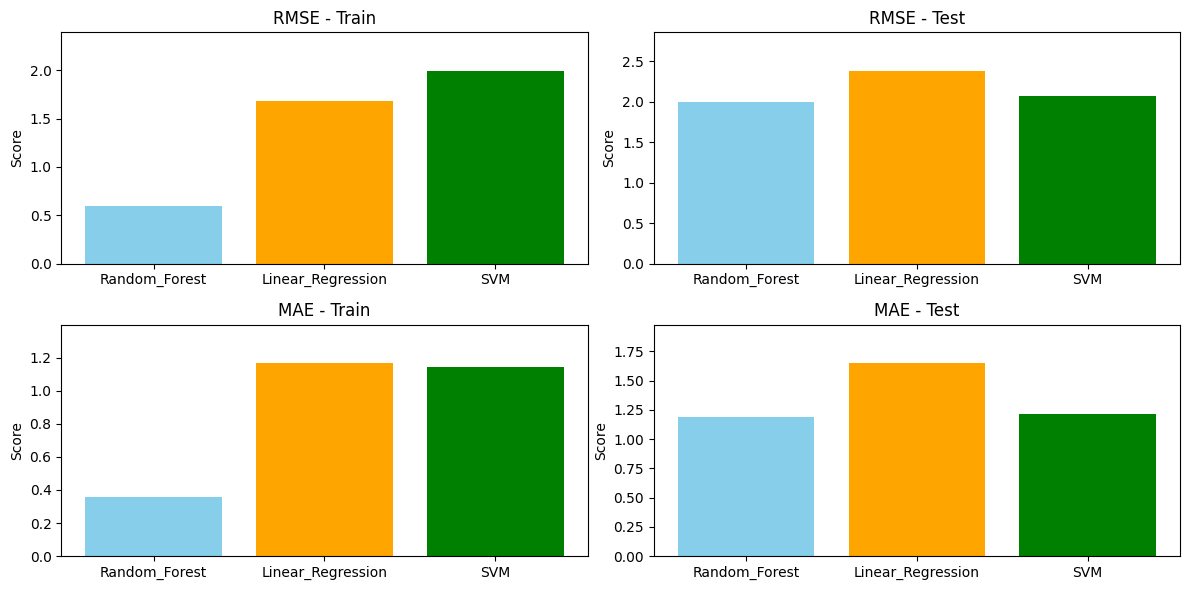

In [ ]:
import matplotlib.pyplot as plt

titles = ["RMSE - Train", "RMSE - Test", "MAE - Train", "MAE - Test"]
n_metrics = len(titles)
n_rows = int(np.ceil(n_metrics / 2))
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

for i, title in enumerate(titles):
    tempVals = [results[m][i] for m in results]
    axes[i].bar(results.keys(), tempVals, color=['skyblue','orange','green'])
    axes[i].set_title(title)
    axes[i].set_ylabel('Score')
    axes[i].set_ylim([0, max(tempVals)*1.2])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()